In [1]:
%load_ext autotime

!nvidia-smi -L

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-3b49e2b8-87f0-c515-798b-3492ec05a183)
GPU 1: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-07628ed7-6ef8-fd67-7d03-cb6a89f72de4)


In [2]:
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from multiprocessing import process
from glob import glob
import cv2, matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
IMG_SIZE = (256, 256) 
TRAIN_SIZE = 25_000
VALID_SIZE = 2_500

BATCH_SIZE = 64
PREFETCH_SIZE = 128
NUM_CLASSES = 4
EPOCHS=10

In [5]:
images_pattern = "./data/CelebAMask-HQ/CelebA-HQ-img/*.jpg"
masks_pattern = "./data/preprocess/masks/*.png"

def sort_by_name(path):
  fname = int(path.split('/')[-1].split('.')[0])
  return fname

images_files = sorted(glob(images_pattern), key=sort_by_name)
masks_files = sorted(glob(masks_pattern), key=sort_by_name)

print(images_files[0], masks_files[0])
print(images_files[5534], masks_files[5534])

./data/CelebAMask-HQ/CelebA-HQ-img/0.jpg ./data/preprocess/masks/00000.png
./data/CelebAMask-HQ/CelebA-HQ-img/5534.jpg ./data/preprocess/masks/05534.png


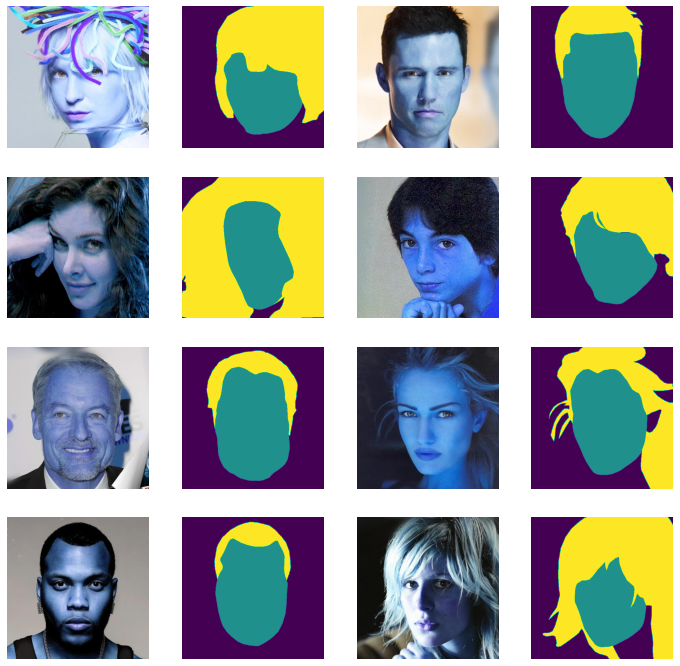

In [6]:
plt.figure(figsize=(12, 12))
for i in range(1, 17, 2):
  idx = np.random.choice(len(images_files))
  img = cv2.imread(images_files[idx], cv2.COLOR_BGR2RGB)
  mask = cv2.imread(masks_files[idx], cv2.IMREAD_GRAYSCALE)
  plt.subplot(4,4,i)
  plt.imshow(img)
  plt.axis('off')
  plt.subplot(4,4,i+1)
  plt.imshow(mask*127)
  plt.axis('off');

In [7]:
X_train_files = images_files[:TRAIN_SIZE]
Y_train_files = masks_files[:TRAIN_SIZE]

X_valid_files = images_files[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
Y_valid_files = masks_files[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]

X_test_files = images_files[TRAIN_SIZE+VALID_SIZE:]
Y_test_files = masks_files[TRAIN_SIZE+VALID_SIZE:]

print(len(X_train_files), len(X_valid_files), len(X_test_files))
print(len(Y_train_files), len(Y_valid_files), len(Y_test_files))

25000 2500 2500
25000 2500 2500


In [8]:
def load_resize_img(img_file):
  img = tf.io.decode_image(
    tf.io.read_file(img_file),
    channels=3,
    dtype=tf.float32,
    expand_animations=False
    )
  img.set_shape(img.shape)
  img = tf.image.resize(img, size=IMG_SIZE)
  
  return img

def load_resize_mask(mask_file):
  mask = tf.io.decode_png(
    tf.io.read_file(mask_file),
    channels=1,
    dtype=tf.uint8
  )
  mask = tf.image.resize(mask, size=IMG_SIZE)
  
  return mask

In [9]:
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train_files).map(load_resize_img).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
Y_train_ds = tf.data.Dataset.from_tensor_slices(Y_train_files).map(load_resize_mask).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

X_valid_ds = tf.data.Dataset.from_tensor_slices(X_valid_files).map(load_resize_img).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
Y_valid_ds = tf.data.Dataset.from_tensor_slices(Y_valid_files).map(load_resize_mask).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

X_test_ds = tf.data.Dataset.from_tensor_slices(X_test_files).map(load_resize_img).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
Y_test_ds = tf.data.Dataset.from_tensor_slices(Y_test_files).map(load_resize_mask).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

0.0 0.9950981
0.0 2.0
(256, 256, 3) (256, 256, 1)


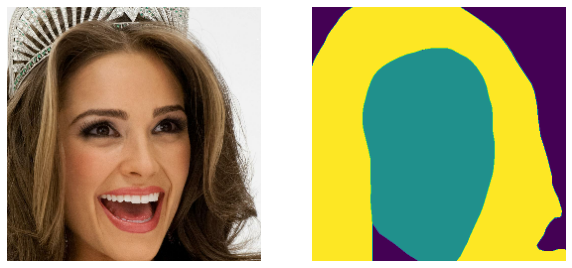

In [10]:
x_batch = next(iter(X_train_ds))
y_batch = next(iter(Y_train_ds))

print(x_batch[0].numpy().min(), x_batch[0].numpy().max()) # 0.0 0.9950981
print(y_batch[0].numpy().min(), y_batch[0].numpy().max()) # 0.0 2.0
print(x_batch[0].shape, y_batch[0].shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow((x_batch[0]));
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((y_batch[0]*127));
plt.axis('off');

In [11]:
keras.backend.clear_session()
filters = 32

inputs = keras.layers.Input(IMG_SIZE+(3,))
x = keras.layers.Conv2D(filters, 3, strides=2, padding='same', use_bias=False)(inputs)

x = keras.layers.SeparableConv2D(filters, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.SeparableConv2D(filters*2, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.SeparableConv2D(filters*2, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.SeparableConv2D(filters*4, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.SeparableConv2D(filters*4, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.SeparableConv2D(filters*8, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.SeparableConv2D(filters*8, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)


x = keras.layers.Conv2DTranspose(filters*8, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2DTranspose(filters*8, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2DTranspose(filters*4, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2DTranspose(filters*2, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2DTranspose(filters, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

output = keras.layers.Conv2D(NUM_CLASSES, (1,1) , padding='same')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      864       
                                                                 
 separable_conv2d (Separable  (None, 128, 128, 32)     1344      
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 separable_conv2d_1 (Separab  (None, 64, 64, 64)       2400  

In [12]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
  optimizer = keras.optimizers.Adam(learning_rate=0.001),
  loss=loss,
  metrics = ['acc']
)

In [13]:
train_ds = tf.data.Dataset.zip((X_train_ds, Y_train_ds))
valid_ds = tf.data.Dataset.zip((X_valid_ds, Y_valid_ds))

In [14]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    "./checkpoints/CelebAMask-base.h5",
    save_best_only=True
  )
]

h = model.fit(train_ds, 
              epochs=EPOCHS,
              validation_data=valid_ds,
              callbacks=callbacks)

Epoch 1/10
391/391 [==============================] - 126s 281ms/step - loss: 0.3211 - acc: 0.8750 - val_loss: 1.8877 - val_acc: 0.3141
Epoch 2/10
391/391 [==============================] - 110s 281ms/step - loss: 0.1876 - acc: 0.9257 - val_loss: 0.1844 - val_acc: 0.9293
Epoch 3/10
391/391 [==============================] - 111s 282ms/step - loss: 0.1631 - acc: 0.9348 - val_loss: 0.1667 - val_acc: 0.9359
Epoch 4/10
391/391 [==============================] - 110s 281ms/step - loss: 0.1492 - acc: 0.9401 - val_loss: 0.1582 - val_acc: 0.9392
Epoch 5/10
391/391 [==============================] - 111s 284ms/step - loss: 0.1394 - acc: 0.9437 - val_loss: 0.1525 - val_acc: 0.9411
Epoch 6/10
391/391 [==============================] - 110s 280ms/step - loss: 0.1316 - acc: 0.9467 - val_loss: 0.1568 - val_acc: 0.9405
Epoch 7/10
391/391 [==============================] - 109s 279ms/step - loss: 0.1256 - acc: 0.9490 - val_loss: 0.1509 - val_acc: 0.9425
Epoch 8/10
391/391 [============================

In [15]:
model = keras.models.load_model("./checkpoints/CelebAMask-base.h5")

test_ds = tf.data.Dataset.zip((X_test_ds, Y_test_ds))

model.evaluate(test_ds)

40/40 [==============================] - 3s 52ms/step - loss: 0.1580 - acc: 0.9406


[0.15798304975032806, 0.9405670166015625]

(256, 256, 3) (256, 256, 1)
(1, 256, 256, 4)


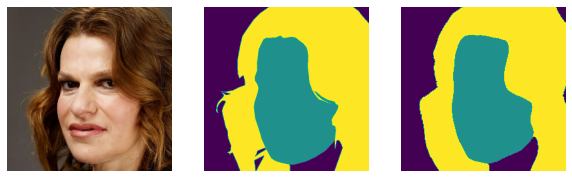

In [19]:
img = load_resize_img(X_test_files[0]).numpy()
label = load_resize_mask(Y_test_files[0]).numpy()
print(img.shape, label.shape)


pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
print(pred.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow((img*255).astype('uint8'));
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow((label*127));
plt.axis('off');
plt.subplot(1, 3, 3)
plt.imshow((np.argmax(pred[0], axis=2)));
plt.axis('off');
